In [111]:
import os
import numpy
import random
import matplotlib
import matplotlib.pyplot as plt

WORK_SPACE = os.getcwd()

PIXEL_PAIRS_MAX = 300
# southern earth
MONTH_LABEL = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


def display_pts_b3_b4(sr_misr_list, sr_ahi_list, r2_list, rmse_r_list, bias_r_list, match_type):
    plt.figure(figsize=(10,4.5))
    ax = plt.axes()
    ax.grid(linestyle='--', linewidth=0.3)
    ax2 = ax.twinx()

    color_sr = ['#FF4500', '#8B0000']
    color_p = ['#3498DB', '#6C3483']
    
    # no-data mask
    f_temp = r2_list[0]
    f_temp = numpy.insert(f_temp, [0, len(f_temp)], [f_temp[-1:], f_temp[0]])
    if match_type == 'RAA':
        for sr_idx in range(len(f_temp)):
            if f_temp[sr_idx] <= 0:
                ax.axvline(sr_idx, color='whitesmoke', linewidth=50.0)
    # mean LSR from AHI and MISR
    m_sr_list = (sr_misr_list+sr_ahi_list)*0.5
                
    # display values
    band_labels = ['Band3', 'Band4']
    sr_med_a = []
    plt_hs = []
    plt_ls = []
    for idx in range(len(band_labels)):
        band_label = band_labels[idx]
        # LSR
        sr_month = m_sr_list[idx]
        sr_month_1d = numpy.array([numpy.median(sr_month[sr_idx]) for sr_idx in range(len(sr_month))])
        sr_month_1d[sr_month_1d <= 0] = numpy.nan
        sr_month_1d = numpy.insert(sr_month_1d, [0, len(sr_month_1d)], [sr_month_1d[-1:], sr_month_1d[0]])
        sr_med_a.append(sr_month_1d)
        sr_month[sr_month <= 0] = numpy.nan
        ax.boxplot(sr_month.T,
                   patch_artist=True,
                   showfliers=False,
                   boxprops=dict(facecolor=color_sr[idx],color=color_sr[idx], linewidth=0.8, alpha=0.2),
                   medianprops=dict(color=color_sr[idx], linewidth=1),
                   whiskerprops=dict(color=color_sr[idx], linewidth=0.8, alpha=0.3),
                   capprops=dict(color=color_sr[idx], linewidth=0.8, alpha=0.3))
        a, =ax.plot(numpy.ones(12)*-1, color=color_sr[idx], label=band_label+'_LSR', linewidth=10, alpha=0.2)
        plt_ls.append(a)
        # para
        rmse_r_month = rmse_r_list[idx]
        rmse_r_month[rmse_r_month == 0] = numpy.nan
        bias_r_month = bias_r_list[idx]
        bias_r_month[bias_r_month <= 0] = numpy.nan
        
        c, = ax2.plot([i for i in range(1,13,1)], rmse_r_month, 'x', color=color_p[idx], label=band_label + '_RRMSE', markersize=14, alpha=0.8)
        d, = ax2.plot([i for i in range(1,13,1)], bias_r_month, '.', color=color_p[idx], label=band_label + '_Rbias', markersize=10, alpha=0.8)
        plt_hs.append(c)
        plt_hs.append(d)
        
    # NDVI
    NDVI_mon = numpy.zeros(14,)    
    print(len(sr_med_a[0]))
    for mon_sr_idx in range(len(sr_med_a[0])):
        mon_b3 = sr_med_a[0][mon_sr_idx]
        mon_b4 = sr_med_a[1][mon_sr_idx]
        if numpy.isnan(mon_b3) or numpy.isnan(mon_b4):
            NDVI_mon[mon_sr_idx] = numpy.NaN
        else:
            NDVI_mon[mon_sr_idx] = (mon_b4-mon_b3)/(mon_b4+mon_b3)
    ndvi_h, =ax.plot([i for i in range(0,14,1)], NDVI_mon, 's', color='g', label='NDVI', markersize=8)

    ax.minorticks_on()
    x_minor_locator = plt.MultipleLocator(1)
    x_major_locator = plt.MultipleLocator(1)
    ax.xaxis.set_minor_locator(x_minor_locator)
    ax.xaxis.set_major_locator(x_major_locator)
    y_minor_locator = plt.MultipleLocator(0.1)
    y_major_locator = plt.MultipleLocator(0.1)
    ax.yaxis.set_minor_locator(y_minor_locator)
    ax.yaxis.set_major_locator(y_major_locator)
    
    y2_major_locator = plt.MultipleLocator(10)
    y2_minor_locator = plt.MultipleLocator(10)
    ax2.yaxis.set_major_locator(y2_major_locator)
    ax2.yaxis.set_minor_locator(y2_minor_locator)

    ax.tick_params(axis="x", which='minor', length=5, direction='out', labelsize=12)
    ax.tick_params(axis="x", which='major', length=5, direction='out', labelsize=12)
    ax.tick_params(axis="y", which='minor', length=5, direction='in', labelsize=12)
    ax.tick_params(axis="y", which='major', length=5, direction='in', labelsize=12)

    plt.xticks([i for i in range(1, 13, 1)], MONTH_LABEL, size=20)
    plt.xlim((0.5, 12.5))
    
    ax.set_ylim((0.0, 0.61))
    ax.set_ylabel('mean LSR, NDVI from AHI & MISR', size=14)
    ax2.set_ylim((-40, 21))
    ax2.set_ylabel('RRMSE (%), Rbias (%)', size=14)
    
    plt.xlabel('Month', size=14)
    
    first_legend = ax.legend(handles=plt_hs, markerscale=0.8, loc='lower right', ncol=2)
    ax.add_artist(first_legend)
    plt_ls.append(ndvi_h)
    ax.legend(handles=plt_ls, markerscale=0.8, loc='lower left', ncol=3)
    
    plt.savefig(WORK_SPACE + '/VZA26_' + match_type + '_month_NDVI.png', dpi=600)
    plt.show()
    plt.clf()


def show_para(mon_para, match_type):
    sr_misr_list = numpy.array(mon_para['sr_misr_list'])
    sr_ahi_list = numpy.array(mon_para['sr_ahi_list'])
    
    r2_list = numpy.array(mon_para['r2_list'])
    rmse_r_list = numpy.array(mon_para['rmse_r_list'])
    bias_r_list = numpy.array(mon_para['bias_r_list'])
    
    display_pts_b3_b4(sr_misr_list, sr_ahi_list, r2_list, rmse_r_list, bias_r_list, match_type)

14


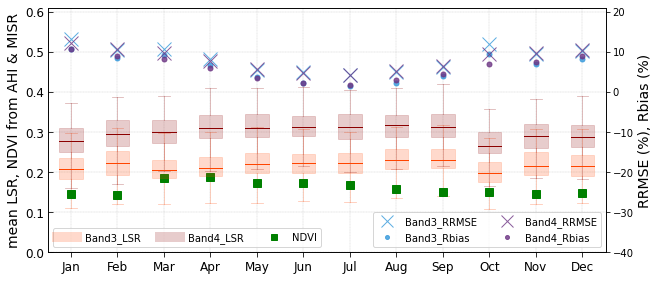

<Figure size 432x288 with 0 Axes>

In [115]:
## LC = 7
raa_month_para_npy = os.path.join(WORK_SPACE, '26_Ray_sr_para.npy')
raa_month_para = numpy.load(raa_month_para_npy, allow_pickle=True)[0]
show_para(raa_month_para, 'Ray')